<a href="https://colab.research.google.com/github/pparutto/BINF2025_TP5/blob/main/BINF_TP5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# *TP5 Reconstruction de génome par alignement sur une référence - Algorithme bowtie et transformée de Burrows-Wheeler*

On cherche à reconstruire le génome d'un organisme dont l'espèce a déjà été séquencé. On va utiliser le génome existant pour guider notre reconstruction en cherchant la position de chaque fragment séquencé dans le génome de référence.

On appelle read un fragment séquencé. La taille d'un read dépend de la mêthode de séquençage. La méthode de Sanger produit des reads d'environ 1000 nucléotides alors que les méthodes de séquençage nouvelle génération vont avoir des reads plus courts d'environ 100 nucléotides.

Les génomes ayant des tailles de l'ordre de 100 000 paires de bases et plus, leur séquençage requiert l'acquisition de milliers voirs millions de reads dont il faut trouver la position dans le génome de référence. Pour que cette méthode soit viable, il faut être capable d'effectuer cette recherche de manière efficace.

La méthode bowtie propose une solution à ce problème basé sur le calcul de la tranformée de Burrows-Wheeler du génome de référence. La transformée de Burrow-Wheeler est une structure basée sur l'ordonancement des préfixes / suffixes d'une séquence permettant une recherche efficace de sous-séquence. Pour pouvoir faire le lien entre transformée et séquence d’origine, on va aussi calculer un index faisant la correspondance entre un caractère de la séquence transformée et la position d’apparition du préfixe correspondant.

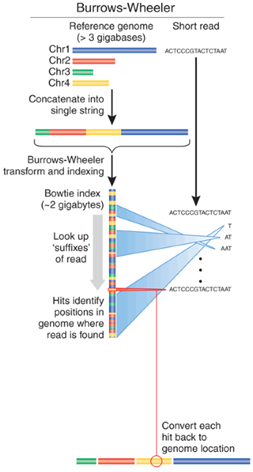

## Exercice 1 : Transformée de Burrows-Wheeler

La transformée de Burrows-Wheeler (BWT) s’obtient en triant par ordre lexicographique toutes les permutations circulaires possibles d’une séquence, et en conservant le dernier caractère de chacune.

Ecrire la fonction BWT(s) -> str qui retourne la transformée BW de la séquence s en effectuant les étapes suivantes :


1. Ajouter un caractère $ à la fin de s (celui-ci servira pour la transformée inverse).
2. Générer la liste perm toutes les permutations circulaires de s (on fait passer la dernière lettre au début de s).
3. Générer un tableau d’indice qui contient l’ordre de chaque permutation.
4. Trier le tableau d’indices et perm par ordre lexicographique de perm.
5. Retourner la séquence contenant le dernier caractère de chaque permutation dans l’ordre lexicographique ainsi que le tableau d’indices.


In [2]:
def BWT(s):
    s = s + '$'
    perm = []
    for i in range(len(s)):
        perm.append((s[i:]+s[:i], i))
    perm.sort(key=lambda x: x[0])
    perm = [p for p in perm if p[1] != len(s)-1]
    bwt = ''.join(p[0][-1] for p in perm)
    sorted_indices = [p[1] for p in perm]
    return bwt, sorted_indices

print(BWT("banana"))
# ('annb$aa', [5, 3, 1, 0, 4, 2])


('nnb$aa', [5, 3, 1, 0, 4, 2])


### Exemple

Transformée de chien :

* Ajouter un caractère \\$ à la fin : chien$

* Générer le tableau perm des permutations cirulaires :

$$
\begin{array}{l}
chien$\\
$chien\\
n$chie\\
en$chi\\
ien$ch\\
hien$c
\end{array}
$$
* Trier ce tableau par ordre lexicographique :
$$
\begin{array}{l}
$chien\\
chien$\\
en$chi\\
hien$c\\
ien$ch\\
n$chie
\end{array}
$$
* La transformée est la dernière colonne de ce tableau (le dernier caractère pour chaque ligne) : n$iche


## Exercice 2 : Transformée inverse

Pour vérifier que la transformée est correcte, on va implémenter la transformée inverse. Pour ce faire, on va recréer l’ensemble des permutations de manière itérative en faisant un nombre d’itérations égal à la taille de la transformée. On va commencer avec un ensemble de séquences vides qu’on appelle table de même taille que la transformée qu’on va modifier à chaque itération :

* Pour chaque caractère en position i de la transformee, l’ajouter au début de la ième séquence de table.
* Trier table par ordre lexicographique.

Le résultat est la séquence de table qui se termine par le caractère $. Notez que c’est pour ça qu’on a besoin d’ajouter ce caractère au moment de la transformée.

Ecrivez la fonction iBWT(t) -> str qui retourne la transformée inverse de la transformée BW t.


In [3]:
def iBWT(t):
    n = len(t)
    table = [""] * n
    
    for _ in range(n):
        for i in range(n):
            table[i] = t[i] + table[i]
        
        table.sort()
    
    for seq in table:
        if seq.endswith('$'):
            return seq 

print (iBWT("annb$aa"))
# 'banana$'

banana$


### Exemple :
Transformée inverse de n$iche :

$$
\begin{array}{lllllllllll}
ADD1 & SORT1 & ADD2 & SORT2 & ADD3 & SORT3 & ADD4 & SORT4 & ADD5 & SORT5 & ADD6\\
n & $ & n$ & $c & n$c & $ch & n$ch & $chi & n$chi & $chie & n$chie\\
$ & c & $c & ch & $ch & chi & $chi & chie & $chie & chien  & $chien\\
i & e & ie & en & ien & en$ & ien$ & en$c & ien$c & en$ch & ien$ch\\
c & h & ch & hi & chi & hie & chie & hien & chien & hien$ & chien$\\
h & i & hi & ie & hie & ien & hien & ien$ & hien & ien$c & ien$c\\
e & n & en & n$ & en$ & n$c & en$c & n$ch & en$ch & n$chi & en$chi\\
\end{array}
$$


### Exercice 3 : Recherche d’un mot dans la transformée

Maintenant que l’on dispose de la transformée, on va développer un algorithme permettant de trouver efficacement si un mot se trouve dedans. Pour cela on va implémenter l’algorithme suivant qui provient de l’outil Bowtie base sur un principe similaire a la construction de table de l’exercice précédent. L’algorithme va reconstruire itérativement l’ensemble des lignes de la table contenant des fragments de plus en plus longs du mot recherche, jusqu’à obtenir l’ensemble des lignes contenant le mot entier. Vu que la table est toujours triée lexicographiquement, on sait que ces séquences vont se trouver cote a cote. L’algorithme est un peu plus complexe que la transformée inverse de l’exercice précédent car il ne reconstruit pas la table entière mais se base sur les propriétés de celle-ci pour trouver les indices :

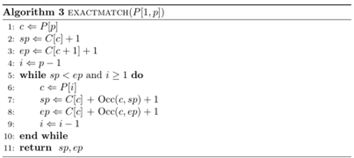

Ou P est la séquence recherchée de taille p, C est un tableau qui donne pour chaque caractère le nombre d’occurrences dans la transformée de caractères qui lui sont lexicographiquement inferieurs et Occ(c,k) est une fonction qui retourne le nombre d’occurrences du caractère c dans la transformée jusqu’à la position k (non-inclue). Les indices sp et ep indiquent le début et la fin respectivement des lignes contenant un fragment de P dans la table. Si P est présente dans la transformée, alors elle sera présente dans toutes les séquences entre les indices sp et ep. Le tableau C peut être précalculé. Attention dans l’algorithme ci-dessus les indices commencent à 1.

Ecrivez la fonction exactmatch(p, bwt) -> (int, int) qui retourne la paire d'indices (sp, ep) (avec sp < ep) de toutes les séquences dans la transformée bwt qui contiennent la sous-séquence s.

In [5]:
def exactmatch(p, bwt):
    C = compute_C(bwt)
    
    m = len(bwt)
    sp = 1
    ep = m
    
    for i in range(len(p) - 1, -1, -1):
        c = p[i]
        
        if c not in C:
            return (1, 0)
        
        sp = C[c] + Occ(bwt, c, sp - 1)
        ep = C[c] + Occ(bwt, c, ep)
        
        if sp > ep:
            return (1, 0)
    
    return (sp, ep)

def compute_C(bwt):
    char_count = {}
    for char in bwt:
        char_count[char] = char_count.get(char, 0) + 1
    
    sorted_chars = sorted(char_count.keys())
    
    C = {}
    current_sum = 0
    for char in sorted_chars:
        C[char] = current_sum
        current_sum += char_count[char]
    
    return C

def Occ(bwt, c, k):
    k_adjusted = max(0, k)
    return bwt[:k_adjusted].count(c)

print(exactmatch("ana", "annb$aa"))
# (2, 4)

(2, 4)


## Exercice 4: retrouver les indices dans la séquence d'origine

A ce stade, il reste une feinte !! En effet, les indices que l’on a récupérés sont des indices dans la transformée et non dans la séquence d’origine. Or ce qui nous intéresse c’est d’obtenir toutes les positions ou apparaissent la séquence recherchée dans la séquence d’origine. Pour ce faire, on va se baser sur le tableau d’indices que l’on a calculé dans la transformée. Ce tableau fait un lien régulier entre une position dans la transformée et position dans la séquence de base. Pour chaque position sp≤k≤se on va chercher si k est dans le tableau d’indice, si oui alors on le retourne, sinon on va dérouler la transformée inverse jusqu’à tombe sur un indice présent dans le tableau d’indice et on retourne la position correspondante plus le nombre d’étapes de transformées inverses effectués. L’algorithme est le suivant :

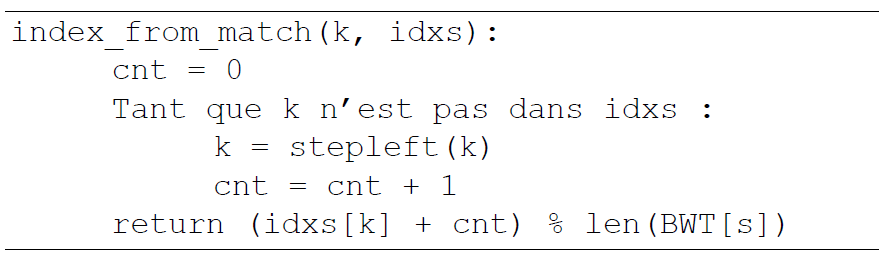

ou k est l’indice recherché, idxs le tableau d’indices et stepleft est la fonction suivante :

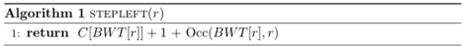

Notez que le modulo apparait car on peut se retrouver à dépasser la taille de la transformée initiale dans la recherche de l’indice le plus proche.

Ecrivez la fonction index_from_match(k, idxs) -> int qui retourne l'indice dans la séquence d'origine à partir de k l'indice dans la transformée et idxs le tableau des correspondances des positions.

In [6]:
def index_from_match(k, idxs):
    n = len(idxs)
    return stepleft(k, idxs, n)

def stepleft(k, idxs, n, count=0):
    if count >= n:
        return -1
    
    if k in idxs:
        return idxs.index(k)
    
    return stepleft((k - 1) % n, idxs, n, count + 1)

print(index_from_match(2, [0, 1, 2, 3, 4, 5]))
# 2

2


## Exercice 5 : Transformée progressive

Le calcul de la transformée BW a un énorme coût en mémoire (il faut déterminer l’ordre des préfixes pour chaque position) ce qui la rend inutilisable pour des génomes. Une version légèrement modifiée permet d’échanger de la consommation mémoire contre du temps de calcul en séparant l’ensemble des suffixes à trier en k sous-ensembles, générer la transformée pour chaque sous-ensemble et les concaténer. Pour générer les sous-ensembles, on va simplement tirer k positions aléatoires le long de la séquence.

Ecrivez la fonction BWT_prog(s, k) -> str qui retourne la transformée de la séquence s en utilisant k graînes.


In [ ]:
print("Votre code ici !")

## Exercice 6: reconstruction de génome

Téléchargez le génome de la mitochondrie humaine: https://www.dropbox.com/scl/fi/ux5m9r80ejm4lz7w3qv0c/sequence_mito.fasta?rlkey=qoaz38vwmg3fgkymx09c7m59j&dl=0
Téléchargez l'ensemble des reads ici: https://www.dropbox.com/scl/fi/uajxylv3yfo1is876x1e9/reads_sequence_mito_l69_seed43_N2000_mu0_norc.fasta?rlkey=h16uoh8xjostqbbmy1tc1k86d&dl=0

1. Calculez la transformée BW du génome
2. Alignez chaque read sur le génome
3. Calculez la séquence concessus